# Enhanced Airline Delay Economics Analysis
## Extended Analysis with Route, Time, and Network Metrics

**Goal:** Extended analysis of airline performance including route efficiency, temporal patterns, and network effects.

**Dataset:** Bureau of Transportation Statistics — Airline On-Time Performance Data

**Note:** This is an enhanced version of analysis_fixed.ipynb with additional metrics.

## 1. Setup & Imports

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import networkx as nx
from collections import defaultdict
import calendar
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Imports complete")

✓ Imports complete


## 2. Data Loading

**BTS Column Names (2024 format):**
- `YEAR`, `MONTH`, `DAY_OF_MONTH`
- `OP_UNIQUE_CARRIER` (airline code)
- `ORIGIN`, `DEST` (airport codes)
- `ARR_DELAY`, `DEP_DELAY` (in minutes)
- `DISTANCE` (in miles)
- `CANCELLED`, `DIVERTED`

In [13]:
# Define columns to load (using correct BTS column names)
columns_to_load = [
    'YEAR', 'MONTH', 'DAY_OF_MONTH',
    'OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST',
    'ARR_DELAY', 'DEP_DELAY', 'DISTANCE',
    'CANCELLED', 'DIVERTED'
]

# Load data
data_file = '../data/airline_ontime.csv'

try:
    df = pd.read_csv(data_file, usecols=columns_to_load, low_memory=False)
    
    # Rename columns to match our analysis code
    df = df.rename(columns={
        'YEAR': 'Year',
        'MONTH': 'Month',
        'DAY_OF_MONTH': 'DayofMonth',
        'OP_UNIQUE_CARRIER': 'Carrier',
        'ORIGIN': 'Origin',
        'DEST': 'Dest',
        'ARR_DELAY': 'ArrDelay',
        'DEP_DELAY': 'DepDelay',
        'DISTANCE': 'Distance',
        'CANCELLED': 'Cancelled',
        'DIVERTED': 'Diverted'
    })
    
    print(f"✓ Data loaded: {len(df):,} rows")
    print(f"✓ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    print(f"✓ Columns: {list(df.columns)}")
    
except FileNotFoundError:
    print("❌ Data file not found. Please download BTS data and place it in ../data/")
    print("   See DATA_DOWNLOAD_GUIDE.md for instructions")
    df = None

✓ Data loaded: 7,033,608 rows
✓ Memory usage: 1630.0 MB
✓ Columns: ['Year', 'Month', 'DayofMonth', 'Carrier', 'Origin', 'Dest', 'DepDelay', 'ArrDelay', 'Cancelled', 'Diverted', 'Distance']


In [14]:
# Display first few rows and basic info
if df is not None:
    display(df.head())
    print("\nDataset Info:")
    df.info()

,Year,Month,DayofMonth,Carrier,Origin,Dest,DepDelay,ArrDelay,Cancelled,Diverted,Distance
0,2025,1,1,AA,ABQ,DFW,-8.00,-21.00,0.00,0.00,569.00
1,2025,1,1,AA,ABQ,DFW,-5.00,-22.00,0.00,0.00,569.00
2,2025,1,1,AA,ABQ,DFW,-3.00,-23.00,0.00,0.00,569.00
3,2025,1,1,AA,ABQ,DFW,-3.00,-17.00,0.00,0.00,569.00
4,2025,1,1,AA,ABQ,DFW,7.00,17.00,0.00,0.00,569.00



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7033608 entries, 0 to 7033607
Data columns (total 11 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Year        int64  
 1   Month       int64  
 2   DayofMonth  int64  
 3   Carrier     object 
 4   Origin      object 
 5   Dest        object 
 6   DepDelay    float64
 7   ArrDelay    float64
 8   Cancelled   float64
 9   Diverted    float64
 10  Distance    float64
dtypes: float64(5), int64(3), object(3)
memory usage: 590.3+ MB


## 3. Data Cleaning

In [15]:
if df is not None:
    print(f"Starting rows: {len(df):,}\n")
    
    # Step 1: Remove cancelled and diverted flights
    df_clean = df[(df['Cancelled'] == 0) & (df['Diverted'] == 0)].copy()
    print(f"After removing cancelled/diverted: {len(df_clean):,} rows")
    
    # Step 2: Remove rows with missing delay values
    df_clean = df_clean.dropna(subset=['ArrDelay', 'DepDelay', 'Distance'])
    print(f"After removing missing values: {len(df_clean):,} rows")
    
    # Step 3: Filter out extreme outliers (delays > 500 minutes or < -60 minutes)
    df_clean = df_clean[
        (df_clean['ArrDelay'] >= -60) & 
        (df_clean['ArrDelay'] <= 500) &
        (df_clean['Distance'] > 0)
    ]
    print(f"After removing outliers: {len(df_clean):,} rows")
    
    # Step 4: Consolidate regional carriers under American Airlines
    regional_to_mainline = {
        'MQ': 'AA',  # Envoy Air -> American Airlines
        'OH': 'AA',  # PSA Airlines -> American Airlines
        'PI': 'AA'   # Piedmont Airlines -> American Airlines
    }
    df_clean['Carrier'] = df_clean['Carrier'].replace(regional_to_mainline)
    print("\nConsolidated regional carriers under American Airlines (AA)")
    
    # Step 5: Filter to top carriers and airports (expanded selection)
    top_carriers = df_clean['Carrier'].value_counts().head(15).index
    top_airports = df_clean['Origin'].value_counts().head(50).index
    
    df_mvp = df_clean[
        df_clean['Carrier'].isin(top_carriers) &
        df_clean['Origin'].isin(top_airports)
    ].copy()
    
    print(f"\nExpanded dataset (top 15 carriers, top 50 airports): {len(df_mvp):,} rows")
    print(f"\nTop 15 Carriers: {list(top_carriers)}")
    print(f"Top 50 Airports: {list(top_airports)}")
    
    # Clean up
    df = df_mvp
    del df_clean, df_mvp
    
    print("\n✓ Data cleaning complete")

Starting rows: 7,033,608

After removing cancelled/diverted: 6,924,735 rows
After removing missing values: 6,924,735 rows
After removing outliers: 6,911,519 rows

Consolidated regional carriers under American Airlines (AA)

Expanded dataset (top 15 carriers, top 50 airports): 5,434,507 rows

Top 15 Carriers: ['AA', 'WN', 'DL', 'OO', 'UA', 'YX', 'AS', 'B6', 'NK', 'F9', 'G4', '9E', 'HA']
Top 50 Airports: ['ATL', 'DEN', 'DFW', 'ORD', 'CLT', 'PHX', 'LAX', 'LAS', 'SEA', 'MCO', 'BOS', 'LGA', 'SFO', 'DCA', 'DTW', 'EWR', 'MSP', 'IAH', 'SLC', 'JFK', 'MIA', 'BNA', 'PHL', 'BWI', 'SAN', 'FLL', 'AUS', 'TPA', 'MDW', 'DAL', 'STL', 'HNL', 'PDX', 'SMF', 'RDU', 'IAD', 'HOU', 'MSY', 'SJC', 'MCI', 'IND', 'CMH', 'SNA', 'PIT', 'SAT', 'CLE', 'OAK', 'CVG', 'SJU', 'RSW']

✓ Data cleaning complete


## 4. Feature Computation

In [16]:
if df is not None:
    # FAA estimated cost per minute of delay
    COST_PER_MINUTE = 47.10/60  # Updated to FAA VOT estimate
    
    # Compute delay cost (only for positive delays)
    df['delay_cost'] = df['ArrDelay'].apply(lambda x: max(0, x) * COST_PER_MINUTE)
    
    # Compute normalized cost per mile (using square root of distance to reduce distance penalty)
    df['cost_per_mile'] = df['delay_cost'] / (df['Distance'] ** 0.5)
    
    # Binary flag for significant delays (> 15 minutes)
    df['is_delayed'] = (df['ArrDelay'] > 15).astype(int)
    
   # Add day of week
    date_df = pd.DataFrame({
        'year': df['Year'],
        'month': df['Month'],
        'day': df['DayofMonth']  # Map DayofMonth to 'day' as pandas expects
    })
    df['day_of_week'] = pd.to_datetime(date_df).dt.day_name()
    
    # Create route identifier
    df['route'] = df['Origin'] + '-' + df['Dest']
    
    # Categorize flight distance
    df['distance_category'] = pd.cut(
        df['Distance'],
        bins=[0, 500, 1000, 1500, 2000, float('inf')],
        labels=['Short (<500mi)', 'Medium (500-1000mi)', 'Long (1000-1500mi)',
               'Very Long (1500-2000mi)', 'Ultra Long (>2000mi)']
    )
    
    # Display sample of new features
    print("Sample of computed features:\n")
    display(df[[
        'Carrier', 'Origin', 'Dest', 'route', 'day_of_week',
        'ArrDelay', 'Distance', 'distance_category',
        'delay_cost', 'cost_per_mile', 'is_delayed'
    ]].head(10))
    
    print("\n✓ Feature computation complete")

Sample of computed features:



,Carrier,Origin,Dest,route,day_of_week,ArrDelay,Distance,distance_category,delay_cost,cost_per_mile,is_delayed
12,AA,ATL,AUS,ATL-AUS,Wednesday,-17.00,813.00,Medium (500-1000mi),0.00,0.00,0
13,AA,ATL,AUS,ATL-AUS,Wednesday,-7.00,813.00,Medium (500-1000mi),0.00,0.00,0
14,AA,ATL,CLT,ATL-CLT,Wednesday,-2.00,226.00,Short (<500mi),0.00,0.00,0
15,AA,ATL,DFW,ATL-DFW,Wednesday,-16.00,731.00,Medium (500-1000mi),0.00,0.00,0
16,AA,ATL,DFW,ATL-DFW,Wednesday,11.00,731.00,Medium (500-1000mi),8.63,0.32,0
17,AA,ATL,DFW,ATL-DFW,Wednesday,-20.00,731.00,Medium (500-1000mi),0.00,0.00,0
18,AA,ATL,DFW,ATL-DFW,Wednesday,-13.00,731.00,Medium (500-1000mi),0.00,0.00,0
19,AA,ATL,DFW,ATL-DFW,Wednesday,-10.00,731.00,Medium (500-1000mi),0.00,0.00,0
20,AA,ATL,DFW,ATL-DFW,Wednesday,-5.00,731.00,Medium (500-1000mi),0.00,0.00,0
21,AA,ATL,LAX,ATL-LAX,Wednesday,-12.00,1947.00,Very Long (1500-2000mi),0.00,0.00,0



✓ Feature computation complete


## 5. Route Performance Analysis

Top 10 Most Costly Routes:


,route,avg_delay_min,median_delay_min,std_delay_min,avg_delay_cost,total_delay_cost,avg_cost_per_mile,delay_rate,distance,primary_carrier,num_flights
2320,LGA-ORD,7.93,-7.00,53.90,14.27,157441.96,0.53,0.21,733.00,UA,11036
2976,ORD-LGA,7.40,-7.00,48.03,13.28,146177.99,0.49,0.22,733.00,UA,11008
50,ATL-EWR,24.68,1.00,64.03,23.69,139414.43,0.87,0.34,746.00,DL,5885
2435,MCO-EWR,16.86,-5.00,62.30,20.26,127919.68,0.66,0.28,937.00,UA,6315
2248,LAX-SFO,5.69,-6.00,38.42,11.25,127565.64,0.61,0.23,337.00,UA,11339
2936,ORD-EWR,17.72,-4.00,61.95,20.69,126892.90,0.77,0.30,719.00,UA,6132
89,ATL-MCO,13.11,-2.00,46.21,14.59,121800.60,0.73,0.26,404.00,DL,8349
359,BOS-DCA,5.95,-8.00,47.41,12.48,115393.43,0.63,0.21,399.00,YX,9243
2410,MCO-ATL,10.38,-4.00,47.93,13.75,115186.98,0.68,0.24,404.00,DL,8376
853,DCA-BOS,4.58,-10.00,46.95,12.34,114148.42,0.62,0.20,399.00,YX,9254



✓ Route analysis complete and exported


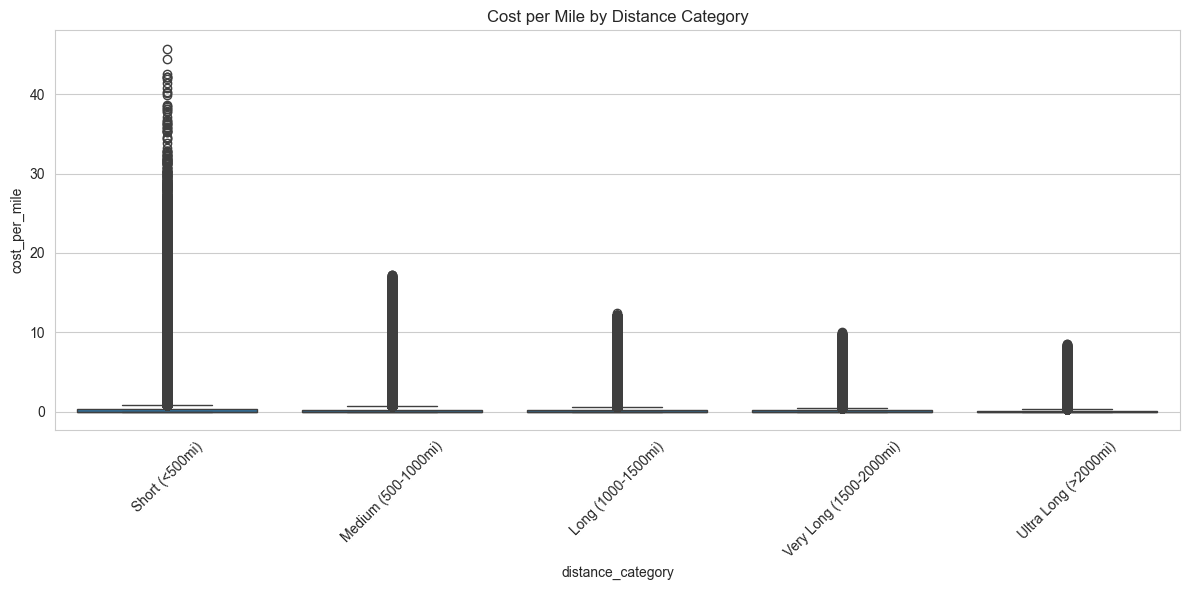

In [17]:
if df is not None:
    # Analyze route performance
    route_summary = df.groupby('route').agg({
        'ArrDelay': ['mean', 'median', 'std'],
        'delay_cost': ['mean', 'sum'],
        'cost_per_mile': 'mean',
        'is_delayed': 'mean',
        'Distance': 'first',
        'Carrier': lambda x: x.value_counts().index[0],  # Most frequent carrier
        'route': 'count'
    }).reset_index()
    
    # Flatten column names
    route_summary.columns = [
        'route', 
        'avg_delay_min', 'median_delay_min', 'std_delay_min',
        'avg_delay_cost', 'total_delay_cost',
        'avg_cost_per_mile',
        'delay_rate',
        'distance',
        'primary_carrier',
        'num_flights'
    ]
    
    # Sort by total delay cost impact
    route_summary = route_summary.sort_values('total_delay_cost', ascending=False)
    
    print("Top 10 Most Costly Routes:")
    display(route_summary.head(10))
    
    # Export for dashboard
    route_summary.to_csv('../outputs/route_summary.csv', index=False)
    print("\n✓ Route analysis complete and exported")
    
    # Visualize route cost distribution
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='distance_category', y='cost_per_mile')
    plt.xticks(rotation=45)
    plt.title('Cost per Mile by Distance Category')
    plt.tight_layout()
    plt.savefig('../outputs/route_cost_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

## 6. Time Pattern Analysis

Day of Week Performance:


,day_of_week,avg_delay_min,median_delay_min,avg_delay_cost,total_delay_cost,delay_rate,num_flights
1,Monday,5.57,-6.00,11.29,9026497.55,0.20,799746
5,Tuesday,0.36,-9.00,8.40,6290822.01,0.15,748652
6,Wednesday,2.21,-8.00,9.31,7056707.26,0.17,757634
4,Thursday,7.27,-5.00,12.07,9925914.45,0.22,822349
0,Friday,6.82,-5.00,11.85,9637895.59,0.22,813119
2,Saturday,2.92,-7.00,9.84,6879252.52,0.18,699365
3,Sunday,7.37,-5.00,12.41,9845265.12,0.22,793642



✓ Time pattern analysis complete and exported


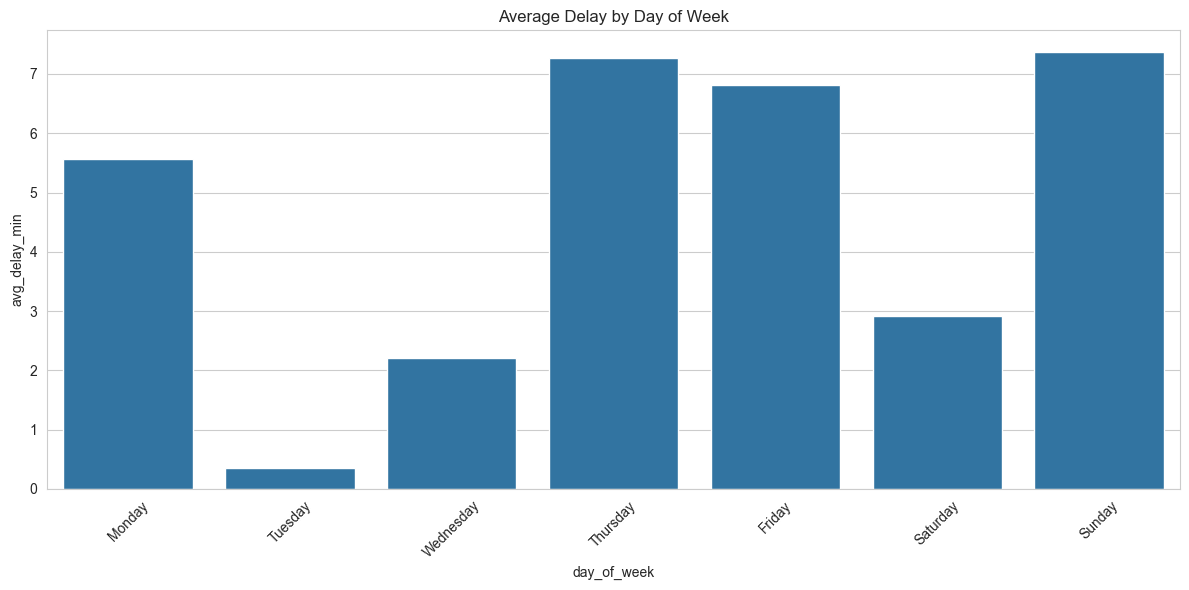

In [18]:
if df is not None:
    # Analyze patterns by day of week
    dow_stats = df.groupby('day_of_week').agg({
        'ArrDelay': ['mean', 'median'],
        'delay_cost': ['mean', 'sum'],
        'is_delayed': 'mean',
        'route': 'count'
    }).reset_index()
    
    # Flatten column names
    dow_stats.columns = [
        'day_of_week',
        'avg_delay_min', 'median_delay_min',
        'avg_delay_cost', 'total_delay_cost',
        'delay_rate',
        'num_flights'
    ]
    
    # Sort by day order
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                 'Friday', 'Saturday', 'Sunday']
    dow_stats['day_of_week'] = pd.Categorical(
        dow_stats['day_of_week'],
        categories=day_order,
        ordered=True
    )
    dow_stats = dow_stats.sort_values('day_of_week')
    
    print("Day of Week Performance:")
    display(dow_stats)
    
    # Export for dashboard
    dow_stats.to_csv('../outputs/time_patterns.csv', index=False)
    print("\n✓ Time pattern analysis complete and exported")
    
    # Visualize day of week patterns
    plt.figure(figsize=(12, 6))
    sns.barplot(data=dow_stats, x='day_of_week', y='avg_delay_min')
    plt.title('Average Delay by Day of Week')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('../outputs/dow_delays.png', dpi=300, bbox_inches='tight')
    plt.show()

## 7. Network Efficiency Analysis

Carrier Hub Analysis:


,carrier,num_hubs,hubs,hub_avg_delay,hub_avg_cost,hub_delay_rate
0,AA,2,"CLT, DFW",8.45,12.98,0.23
2,B6,2,"BOS, JFK",6.48,13.70,0.23
6,HA,2,"HNL, OGG",4.28,6.87,0.15
9,UA,2,"DEN, ORD",4.55,10.82,0.19
11,YX,2,"BOS, LGA",1.30,9.51,0.18
12,9E,2,"ATL, LGA",-4.02,6.41,0.12
1,AS,1,SEA,4.98,9.74,0.23
3,DL,1,ATL,4.73,9.83,0.19
4,F9,1,DEN,7.58,13.12,0.24
5,G4,1,LAS,-1.50,7.93,0.15



✓ Network analysis complete and exported


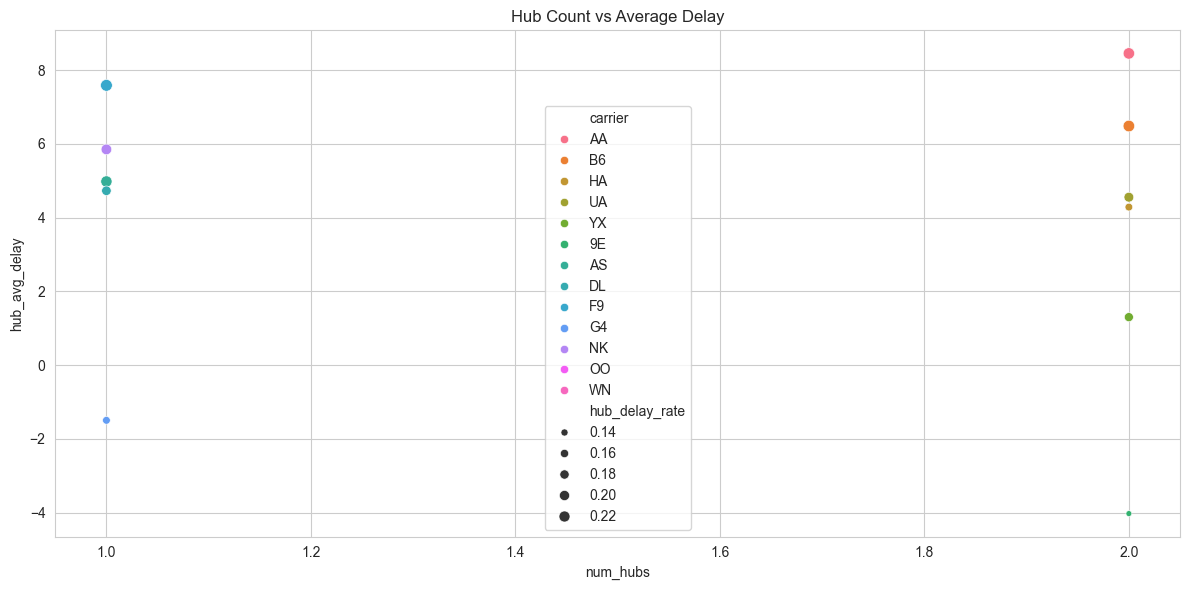

In [19]:
if df is not None:
    # Calculate hub metrics
    hub_metrics_list = []  # Changed to a list for better control
    
    # For each carrier
    for carrier in df['Carrier'].unique():
        carrier_df = df[df['Carrier'] == carrier]
        
        # Count flights per airport (both origin and destination)
        origin_counts = carrier_df['Origin'].value_counts()
        dest_counts = carrier_df['Dest'].value_counts()
        total_flights = pd.concat([origin_counts, dest_counts]).groupby(level=0).sum()
        
        # Identify hubs (airports with > 10% of carrier's flights)
        hubs = total_flights[total_flights > 0.1 * total_flights.sum()].index.tolist()
        
        # Calculate hub performance
        hub_delays = df[
            (df['Carrier'] == carrier) &
            ((df['Origin'].isin(hubs)) | (df['Dest'].isin(hubs)))
        ].agg({
            'ArrDelay': 'mean',
            'delay_cost': 'mean',
            'is_delayed': 'mean'
        })
        
        # Add to metrics list
        hub_metrics_list.append({
            'carrier': carrier,
            'num_hubs': len(hubs),
            'hubs': ', '.join(hubs),
            'hub_avg_delay': hub_delays['ArrDelay'],
            'hub_avg_cost': hub_delays['delay_cost'],
            'hub_delay_rate': hub_delays['is_delayed']
        })
    
    # Convert list to DataFrame
    hub_metrics = pd.DataFrame(hub_metrics_list)
    
    # Sort by number of hubs
    hub_metrics = hub_metrics.sort_values('num_hubs', ascending=False)
    
    print("Carrier Hub Analysis:")
    display(hub_metrics)
    
    # Export for dashboard
    hub_metrics.to_csv('../outputs/network_metrics.csv', index=False)
    print("\n✓ Network analysis complete and exported")
    
    # Visualize hub performance
    plt.figure(figsize=(12, 6))
    sns.scatterplot(
        data=hub_metrics,
        x='num_hubs',
        y='hub_avg_delay',
        size='hub_delay_rate',
        hue='carrier'
    )
    plt.title('Hub Count vs Average Delay')
    plt.tight_layout()
    plt.savefig('../outputs/hub_performance.png', dpi=300, bbox_inches='tight')
    plt.show()

## 8. Original Analysis (Base Metrics)

In [20]:
if df is not None:
    airline_summary = df.groupby('Carrier').agg({
        'ArrDelay': ['mean', 'median', 'std'],
        'delay_cost': ['mean', 'sum'],
        'cost_per_mile': 'mean',
        'is_delayed': ['sum', 'mean'],
        'Distance': 'mean',
        'Carrier': 'count'
    }).reset_index()
    
    # Flatten column names
    airline_summary.columns = [
        'Carrier', 
        'avg_delay_min', 'median_delay_min', 'std_delay_min',
        'avg_delay_cost', 'total_delay_cost',
        'avg_cost_per_mile',
        'num_delayed_flights', 'delay_rate',
        'avg_distance',
        'num_flights'
    ]
    
    # Sort by cost per mile (efficiency)
    airline_summary = airline_summary.sort_values('avg_cost_per_mile')
    
    print("Airline Performance Summary:\n")
    display(airline_summary)
    
    # Export for dashboard
    airline_summary.to_csv('../outputs/airline_summary.csv', index=False)
    print("\n✓ Airline summary exported to outputs/airline_summary.csv")

Airline Performance Summary:



,Carrier,avg_delay_min,median_delay_min,std_delay_min,avg_delay_cost,total_delay_cost,avg_cost_per_mile,num_delayed_flights,delay_rate,avg_distance,num_flights
2,AS,4.50,-3.00,35.16,9.78,1824557.45,0.29,40244,0.22,1495.29,186645
7,HA,4.09,-1.00,28.00,6.88,295922.23,0.31,6412,0.15,1294.80,42990
0,9E,-2.73,-11.00,33.85,7.00,359124.94,0.36,6777,0.13,456.43,51286
4,DL,2.82,-8.00,40.75,9.75,8385929.71,0.36,151881,0.18,1014.31,859963
11,WN,4.04,-6.00,35.38,9.25,10462352.04,0.37,209717,0.19,795.84,1131166
10,UA,3.97,-7.00,43.93,10.87,7476248.16,0.38,127436,0.19,1145.21,687496
8,NK,4.21,-8.00,44.49,11.40,2351892.19,0.41,40295,0.20,961.72,206327
6,G4,6.02,-8.00,48.33,12.41,329429.17,0.44,5379,0.20,909.57,26538
12,YX,0.62,-9.00,38.04,8.95,2322731.00,0.46,42713,0.16,477.45,259543
3,B6,7.02,-7.00,48.97,13.76,2578928.31,0.46,43612,0.23,1258.97,187414



✓ Airline summary exported to outputs/airline_summary.csv


In [21]:
if df is not None:
    airport_summary = df.groupby('Origin').agg({
        'ArrDelay': ['mean', 'median'],
        'delay_cost': ['mean', 'sum'],
        'cost_per_mile': 'mean',
        'is_delayed': 'mean',
        'Origin': 'count'
    }).reset_index()
    
    # Flatten column names
    airport_summary.columns = [
        'Airport',
        'avg_delay_min', 'median_delay_min',
        'avg_delay_cost', 'total_delay_cost',
        'avg_cost_per_mile',
        'delay_rate',
        'num_flights'
    ]
    
    # Sort by cost per mile
    airport_summary = airport_summary.sort_values('avg_cost_per_mile')
    
    print("Airport Performance Summary:\n")
    display(airport_summary)
    
    # Export for dashboard
    airport_summary.to_csv('../outputs/airport_summary.csv', index=False)
    print("\n✓ Airport summary exported to outputs/airport_summary.csv")

Airport Performance Summary:



,Airport,avg_delay_min,median_delay_min,avg_delay_cost,total_delay_cost,avg_cost_per_mile,delay_rate,num_flights
16,HNL,0.38,-3.00,5.61,334525.40,0.26,0.12,59644
33,PDX,1.03,-6.00,7.55,446862.04,0.28,0.15,59176
23,LAX,-0.40,-9.00,8.32,1586313.08,0.29,0.15,190689
31,OAK,-0.28,-8.00,6.66,248965.89,0.29,0.14,37377
43,SJC,-0.45,-8.00,6.83,331671.92,0.30,0.14,48543
41,SEA,3.09,-4.00,8.95,1431880.04,0.30,0.20,159949
45,SLC,0.56,-8.00,7.94,902600.85,0.31,0.15,113701
46,SMF,0.71,-8.00,7.44,424962.89,0.32,0.15,57155
44,SJU,4.72,-7.00,11.60,412344.80,0.32,0.20,35548
35,PHX,2.43,-6.00,8.45,1690053.19,0.33,0.17,199961



✓ Airport summary exported to outputs/airport_summary.csv


## 9. Export Full Dataset

In [22]:
if df is not None:
    # Export full dataset with new features
    tableau_export = df[[
        'Year', 'Month', 'DayofMonth', 'day_of_week',
        'Carrier', 'Origin', 'Dest', 'route',
        'Distance', 'distance_category',
        'ArrDelay', 'DepDelay',
        'delay_cost', 'cost_per_mile', 'is_delayed'
    ]].copy()
    
    tableau_export.to_csv('../outputs/full_dataset_for_tableau.csv', index=False)
    
    print(f"✓ Enhanced dataset exported: {len(tableau_export):,} rows")
    print(f"✓ All files ready in outputs/ directory")
    print(f"\n🚀 Next step: Run dashboard_app_premium.py")

✓ Enhanced dataset exported: 5,434,507 rows
✓ All files ready in outputs/ directory

🚀 Next step: Run dashboard_app_premium.py
